In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5

In [2]:
features = pd.read_csv('../dataset/application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

Train shape:  (10000, 104)
Test shape:  (6000, 104)


## Baseline Model

First we can create a model with the default value of hyperparameters and score it using cross validation with early stopping. Using the cv LightGBM function requires creating a Dataset.

In [9]:
model = lgb.LGBMClassifier(random_state=50)
hyperparameters = model.get_params()
# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)


In [10]:
# Default hyperparamters
# hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


The maximium ROC AUC in cross validation was 0.70867 with std of 0.02098.
The ideal number of iterations was 33.


In [11]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71466 ROC AUC on the test set.


## Objective Function

The first part to write is the objective function which takes in a set of hyperparameter values and returns the cross validation score on the training data. An objective function in Hyperopt must return either a single real value to minimize, or a dictionary with a key "loss" with the score to minimize (and a key "status" indicating if the run was successful or not).

Optimization is typically about minimizing a value, and because our metric is Receiver Operating Characteristic Area Under the Curve (ROC AUC) where higher is better, the objective function will return  1−ROC AUC Cross Validation . The algorithm will try to drive this value as low as possible (raising the ROC AUC) by choosing the next hyperparameters based on the past results.

The complete objective function is shown below. As with random and grid search, we write to a csv file on each call of the function in order to track results as the search progress and so we have a saved record of the search. (The subsample and boosting_type logic will be explained when we get to the domain).

In [13]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [14]:
def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

## Domain

Specifying the domain (called the space in Hyperopt) is a little trickier than in grid search. In Hyperopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images!

In [15]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [16]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

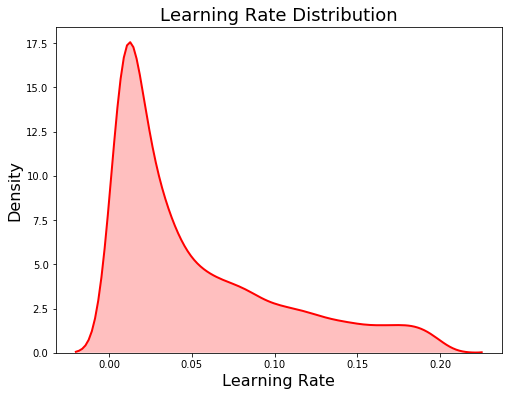

In [17]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

In [42]:
sample(learning_rate)['learning_rate']

0.19428380164751707

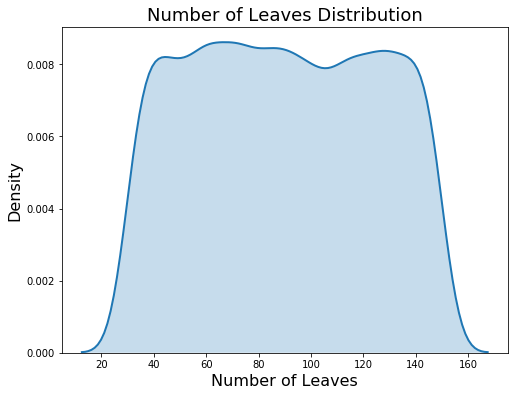

In [43]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [53]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.6444472181352747}}

In [54]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'dart', 'subsample': 0.6444472181352747}

## Complete Bayesian Domain

Now we can define the entire domain. Each variable needs to have a label and a few parameters specifying the type and extent of the distribution. For the variables such as boosting type that are categorical, we use the choice variable. Other variables types include quniform, loguniform, and uniform. For the complete list, check out the documentation for Hyperopt. Altogether there are 10 hyperparameters to optimize.

In [55]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [56]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8556540225190401,
 'is_unbalance': True,
 'learning_rate': 0.12352991930307489,
 'min_child_samples': 240.0,
 'num_leaves': 76.0,
 'reg_alpha': 0.030490172752723255,
 'reg_lambda': 0.5189381980771696,
 'subsample': 0.6801153724179387,
 'subsample_for_bin': 80000.0}

In [57]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'colsample_bytree': 0.9139994620023516,
 'is_unbalance': False,
 'learning_rate': 0.014711143794267812,
 'min_child_samples': 95.0,
 'num_leaves': 53.0,
 'reg_alpha': 0.49664098734550155,
 'reg_lambda': 0.820652441277971,
 'subsample': 1.0,
 'subsample_for_bin': 220000.0}

In [58]:
# Create a new file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.27658.
The optimal number of estimators was 50.


## Optimization Algorithm

The optimization algorithm is the method for constructing the surrogate function (probability model) and selecting the next set of hyperparameters to evaluate in the objective function. Hyperopt has two choices: random search and Tree Parzen Estimator.

The technical details of TPE can be found in this article and a conceptual explanation is in this article. Although this is the most technical part of Bayesian hyperparameter optimization, defining the algorithm in Hyperopt is simple.

In [60]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

In [61]:
tpe_algorithm

<function hyperopt.tpe.suggest>

In [62]:
from hyperopt import Trials

# Record results
trials = Trials()

In [63]:
# Create a file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

## Automated Hyperparameter Optimization in Practice

We have all four parts we need to run the optimization. To run Bayesian optimization we use the fmin function (a good reminder that we need a metric to minimize!)

In [65]:
from hyperopt import fmin

In [66]:
# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

{'boosting_type': 0,
 'colsample_by_tree': 0.6855454591025973,
 'gdbt_subsample': 0.9049582875741105,
 'is_unbalance': 1,
 'learning_rate': 0.01766964896084296,
 'min_child_samples': 320.0,
 'num_leaves': 131.0,
 'reg_alpha': 0.5905867048603399,
 'reg_lambda': 0.20687372242322555,
 'subsample_for_bin': 220000.0}